In [4]:
!pip install torchsummary

# Import

In [5]:
import pandas as pd
import numpy as np
import random
import os
from collections import Counter, defaultdict
from PIL import Image

import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.models as models # VGG16, ResNet50
from torchsummary import summary # summary for models
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

import gc

2024-06-18 06:57:55.059558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 06:57:55.059668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 06:57:55.171673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
class config:
    
    root = "/kaggle/input/handwriting-chinese/ma_2024_1"
    batch_size = 32
    lr = 1e-3
    epochs = 100
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42

# Defined Functions

In [7]:
def split_ids(n, train_size, val_size):
    train_size = int(train_size * n)
    val_size = int(val_size * n)
#     test_size = int(test_size * n)

    train_indices, val_indices = train_test_split(
        np.linspace(0, n - 1, n).astype("int"),
        test_size=val_size,
        random_state=42,
    )

#     train_indices, val_indices = train_test_split(
#         train_indices, test_size=test_size, random_state=42
#     )

    return train_indices, val_indices

def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
# Read in the dataframe
train_data = pd.read_csv(os.path.join(config.root, 'train.csv'))
test_data = pd.read_csv(os.path.join(config.root, 'test.csv'), header=None)
train_data

,file_path,label
0,胎/胎_39.png,0
1,胎/胎_4.png,0
2,胎/胎_1.png,0
3,胎/胎_48.png,0
4,胎/胎_44.png,0
...,...,...
29732,攪/攪_0.png,999
29733,攪/攪_21.png,999
29734,攪/攪_6.png,999
29735,攪/攪_32.png,999


In [9]:
from PIL import Image, ImageEnhance

class EnhanceTransform:
    def __call__(self, img):
        # 对比度增强
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)
        # 锐化
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)
        return img

# transform = transforms.Compose([
#     transforms.Resize((224, 224), interpolation=Image.LANCZOS),  # 使用高质量插值方法
#     EnhanceTransform(),  # 应用自定义增强变换
#     transforms.ToTensor(),  # 将图像转换为张量
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
# ])

# # 打开一张图片
# img_path = "/kaggle/input/handwriting-chinese/ma_2024_1/train/胎/胎_39.png"
# img = Image.open(img_path)

# # 应用transform
# transformed_img = transform(img)

# # 取消标准化以便显示图像
# unnormalize = transforms.Normalize(
#     mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
#     std=[1/0.229, 1/0.224, 1/0.225]
# )
# transformed_img = unnormalize(transformed_img)

# # 将张量转换为 PIL 图像
# transformed_img = transforms.ToPILImage()(transformed_img)

# # 显示原图像和变换后的图像
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# ax[0].imshow(img)
# ax[0].set_title("Original Image")
# ax[0].axis("off")

# ax[1].imshow(transformed_img)
# ax[1].set_title("Transformed Image")
# ax[1].axis("off")

# plt.show()

In [10]:
# class HandwrittenDataset(Dataset):
    
#     def __init__(self, df, transforms=None):
#         self.df = df
#         self.transforms = transforms
#         self.labels = np.array(df['label']) # 標籤
#         self.paths = np.array(df['file_path']) # 影像路徑
        
# #     def __getitem__(self, x):
# #         if self.df.shape[1] == 257:
# #             image, label = self.df.iloc[x, 1:].to_numpy(), self.df.iloc[x, 0]
# #             image, label = torch.tensor(image), torch.tensor(label)
# #             return image, label
# #         else:
# #             image = self.df.iloc[x, :].to_numpy()
# #             return image
        
#     def __getitem__(self, idx):
#         img_name = os.path.join(config.root, "train", self.paths[idx])
#         image = Image.open(img_name)
# #         image = Image.open(img_name).convert('L')  # Convert image to grayscale
# #         image = torch.tensor(image.astype(np.float32))


# #         transform = transforms.ToTensor() # 會是3X50X50


# #         transform = transforms.Compose([
# #             transforms.Resize((224, 224)),  # 調整圖像大小到224x224
# #             transforms.ToTensor(),  # 將圖像轉換為張量
# #             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 標準化
# #         ])


#         transform = transforms.Compose([
#             transforms.Resize((224, 224), interpolation=Image.LANCZOS),  # 使用高质量插值方法
#             EnhanceTransform(),  # 应用自定义增强变换
#             transforms.ToTensor(),  # 将图像转换为张量
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
#         ])
    
#         image = transform(image)
# #         image = torch.tensor(np.array(image))
# #         image = transforms.ToTensor(image)
#         label = self.labels[idx]
#         label = torch.tensor(self.labels[idx])
        
#         if self.transforms:
#             image = self.transforms(image)
        
#         return image, label
        
#     def __len__(self):
#         return self.df.shape[0]

In [11]:
class HandwrittenDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.labels = np.array(df['label']) # 標籤
        self.paths = np.array(df['file_path']) # 影像路徑
        
        
    def __getitem__(self, idx):
        img_name = os.path.join(config.root, "train", self.paths[idx])
        image = Image.open(img_name)
#         transform = transforms.ToTensor()
#         image = transform(image)
        label = self.labels[idx]
        label = torch.tensor(self.labels[idx])
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
    def __len__(self):
        return self.df.shape[0]
    
data_transforms = transforms.Compose([
    EnhanceTransform(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(50, padding=4),
#     transforms.RandomAffine(degrees=30),
#     transforms.RandomAffine(degrees= 0 ,translate=(0.2,0.5)),
#     transforms.RandomAffine(degrees= 0 ,scale=(0.2,0.5)),
#     transforms.RandomAffine(degrees= 0 ,shear=(30)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 颜色抖动
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     transforms.ToTensor()
])


# Defined CNN

In [12]:
# 元模型

# class CNN_Model(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(CNN_Model, self).__init__()
#         # Convolution 1, input_shape=(3,50,50)
#         self.cnn1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
#         self.relu1 = nn.ReLU(inplace=True)
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2)

#         # Convolution 2
#         self.cnn2 = nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU(inplace=True)
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
#         # Convolution 3
#         self.cnn3 = nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=2)
#         self.relu3 = nn.ReLU(inplace=True)
#         self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
#         # Convolution 4
#         self.cnn4 = nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2)
#         self.relu4 = nn.ReLU(inplace=True)
#         self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
#         # Convolution 5
#         self.cnn5 = nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2)
#         self.relu5 = nn.ReLU(inplace=True)
#         self.maxpool5 = nn.MaxPool2d(kernel_size=2)

#         # Fully connected 1, input_shape=(8*12*12)
#         self.fc = nn.Linear(1024, num_classes)
#         self.dropout = nn.Dropout(p=0.2)
    
#     def forward(self, x):
#         out = self.cnn1(x)
#         out = self.relu1(out)
#         out = self.maxpool1(out)
#         out = self.cnn2(out)
#         out = self.relu2(out)
#         out = self.maxpool2(out)
#         out = self.cnn3(out)
#         out = self.relu3(out)
#         out = self.maxpool3(out)
#         out = self.cnn4(out)
#         out = self.relu4(out)
#         out = self.maxpool4(out)
#         out = self.cnn5(out)
#         out = self.relu5(out)
#         out = self.maxpool5(out)
#         out = out.view(out.size(0), -1)
#         out = self.dropout(out)
#         out = self.fc(out)
#         return out




In [13]:
# # 使用Sequential，和上面模型會有一樣效果
# # class config:
    
# #     root = "/kaggle/input/handwriting-chinese/ma_2024_1"
# #     batch_size = 32
# #     lr = 1e-3
# #     epochs = 100
# #     weight_decay = 1e-3
# #     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# #     seed = 42
# class CNN_Model(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(CNN_Model, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),

#             nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(64, 256, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2),
            
#             nn.Conv2d(512, 1024, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=0.2),
#             nn.Linear(1024, num_classes)
#         )
    
#     def forward(self, x):
#         out = self.features(x)
#         out = out.view(out.size(0), -1)
#         out = self.classifier(out)
#         return out

In [14]:
# 使用Sequential，和上面模型會有一樣效果
class Xx_CNN_xX(nn.Module):
    def __init__(self, num_classes=1000):
        super(Xx_CNN_xX, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256*6*6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
# model = Xx_CNN_xX(num_classes=1000)
# print(model)

In [15]:
class VGG16_S(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16_S, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(7 * 7 * 512, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    


In [16]:
# # 一個epoch大概8分鐘
# class VGG16(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(VGG16, self).__init__()
#         self.features = nn.Sequential(
#             # Block 1
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 2
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 3
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 4
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 5
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x
    
# # 測試模型架構
# model = VGG16(num_classes=1000)  # 替換為你的分類數量
# print(model)


# Training

In [17]:
def evaluator(preds, gts):
    
    preds = preds.cpu().numpy() if isinstance(preds, torch.Tensor) else preds
    gts = gts.cpu().numpy() if isinstance(gts, torch.Tensor) else gts
    
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")
    
    return acc, f1

def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, labels in train_loader:
        images = images.to(device=device, dtype=torch.float)
        labels = labels.to(device=device, dtype=torch.long)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        
        predictions.append(preds)
        ground_truths.append(labels)
        
    train_loss /= len(train_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)
    
    return train_loss, 100*train_acc, 100*train_f1
        
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device=device, dtype=torch.float)
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)
            
            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
        
            predictions.append(preds)
            ground_truths.append(labels)
        
    valid_loss /= len(valid_loader)
    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1
    

In [18]:
# # Xx_CNN_xX
# def main():
    
#     seed_everything(config.seed)
    
#     dataset = HandwrittenDataset(train_data)
#     train_ids, val_ids = split_ids(train_data.shape[0], 0.8, 0.2)
#     train_dataset = torch.utils.data.Subset(dataset, train_ids)
#     val_dataset = torch.utils.data.Subset(dataset, val_ids)
# #     test_dataset = torch.utils.data.Subset(dataset, test_ids)

#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
# #     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    
#     criterion = nn.CrossEntropyLoss()
#     device = config.device
#     model =  Xx_CNN_xX()
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         optimizer, 
#         epochs=config.epochs, 
#         steps_per_epoch=train_loader.__len__(),
#         max_lr=config.lr,
#     )
    
#     best_val_loss = float("inf")
#     history = {
#         "train": {
#             "loss": [],
#             "acc": [],
#             "f1": []
#         },
#         "valid": {
#             "loss": [],
#             "acc": [],
#             "f1": [],
#             "mis": []#加上misclassification rate
#         },
#     }
#     for epoch in range(config.epochs):
#         train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
#         valid_loss, valid_acc, valid_f1 = validation(model, val_loader, criterion, device)
#         valid_mis = 100 - valid_acc
        
#         # Log the loss and validation result
#         history["train"]["loss"].append(train_loss)
#         history["train"]["acc"].append(train_acc)
#         history["train"]["f1"].append(train_f1)
#         history["valid"]["loss"].append(valid_loss)
#         history["valid"]["acc"].append(valid_acc)
#         history["valid"]["f1"].append(valid_f1)
#         history["valid"]["mis"].append(valid_mis)

#         print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid Misclassification Rate: {valid_mis:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
#         if valid_loss < best_val_loss:
#             save_file = {
#                 "model": model.state_dict(),
#                 "optimizer": optimizer.state_dict(),
#                 "scheduler": scheduler.state_dict(),
#                 "epoch": epoch,
#                 "args": config
#             }
#             best_val_loss = valid_loss
#             torch.save(save_file, "checkpoint.pth")
#             #儲存(object, 位址)
            
#     best_ckpt = torch.load("checkpoint.pth", map_location=device)
#     #load ckpt onto device
#     model.load_state_dict(best_ckpt["model"])
    
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
#     plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Loss Curves')
#     plt.show()
    
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
#     plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Accuracy Curves')
#     plt.show()
    
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
#     plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation F1 Score Curves')
#     plt.show()
    
        
# if __name__ == "__main__":
#     main()

In [19]:
# # 此為CNN_Model
# def main():
    
#     seed_everything(config.seed)
    
#     dataset = HandwrittenDataset(train_data)
#     train_ids, val_ids = split_ids(train_data.shape[0], 0.8, 0.2)
#     train_dataset = torch.utils.data.Subset(dataset, train_ids)
#     val_dataset = torch.utils.data.Subset(dataset, val_ids)
# #     test_dataset = torch.utils.data.Subset(dataset, test_ids)

#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
# #     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    
#     criterion = nn.CrossEntropyLoss()
#     device = config.device
#     model =  CNN_Model()
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
#     scheduler = torch.optim.lr_scheduler.OneCycleLR(
#         optimizer, 
#         epochs=config.epochs, 
#         steps_per_epoch=train_loader.__len__(),
#         max_lr=config.lr,
#     )
    
#     best_val_loss = float("inf")
#     history = {
#         "train": {
#             "loss": [],
#             "acc": [],
#             "f1": []
#         },
#         "valid": {
#             "loss": [],
#             "acc": [],
#             "f1": [],
#             "mis": []#加上misclassification rate
#         },
#     }
#     for epoch in range(config.epochs):
#         train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
#         valid_loss, valid_acc, valid_f1 = validation(model, val_loader, criterion, device)
#         valid_mis = 100 - valid_acc
        
#         # Log the loss and validation result
#         history["train"]["loss"].append(train_loss)
#         history["train"]["acc"].append(train_acc)
#         history["train"]["f1"].append(train_f1)
#         history["valid"]["loss"].append(valid_loss)
#         history["valid"]["acc"].append(valid_acc)
#         history["valid"]["f1"].append(valid_f1)
#         history["valid"]["mis"].append(valid_mis)

#         print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid Misclassification Rate: {valid_mis:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
#         if valid_loss < best_val_loss:
#             save_file = {
#                 "model": model.state_dict(),
#                 "optimizer": optimizer.state_dict(),
#                 "scheduler": scheduler.state_dict(),
#                 "epoch": epoch,
#                 "args": config
#             }
#             best_val_loss = valid_loss
#             torch.save(save_file, "checkpoint.pth")
#             #儲存(object, 位址)
            
#     best_ckpt = torch.load("checkpoint.pth", map_location=device)
#     #load ckpt onto device
#     model.load_state_dict(best_ckpt["model"])
    
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
#     plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Loss Curves')
#     plt.show()
    
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
#     plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation Accuracy Curves')
#     plt.show()
    
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
#     plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Validation F1 Score Curves')
#     plt.show()
    
        
# if __name__ == "__main__":
#     main()

Epoch[1/100], Train Loss: 6.7451, Train Accuracy: 0.54%, Train F1: 0.20% | Valid Loss: 6.2555, Valid Accuracy: 1.46%, Valid Misclassification Rate: 98.54%, Valid F1: 0.52% | LR: 0.000043
Epoch[2/100], Train Loss: 5.5047, Train Accuracy: 4.61%, Train F1: 3.28% | Valid Loss: 4.6230, Valid Accuracy: 12.43%, Valid Misclassification Rate: 87.57%, Valid F1: 9.29% | LR: 0.000050
Epoch[3/100], Train Loss: 3.6259, Train Accuracy: 23.62%, Train F1: 21.46% | Valid Loss: 2.6393, Valid Accuracy: 41.85%, Valid Misclassification Rate: 58.15%, Valid F1: 38.48% | LR: 0.000063
Epoch[4/100], Train Loss: 2.0956, Train Accuracy: 49.89%, Train F1: 48.53% | Valid Loss: 1.7247, Valid Accuracy: 57.86%, Valid Misclassification Rate: 42.14%, Valid F1: 55.64% | LR: 0.000082
Epoch[5/100], Train Loss: 1.3594, Train Accuracy: 65.23%, Train F1: 64.61% | Valid Loss: 1.2268, Valid Accuracy: 69.13%, Valid Misclassification Rate: 30.87%, Valid F1: 67.28% | LR: 0.000104
Epoch[6/100], Train Loss: 0.9914, Train Accuracy: 73

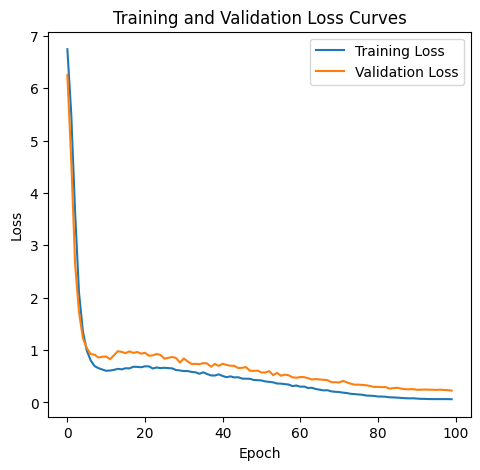

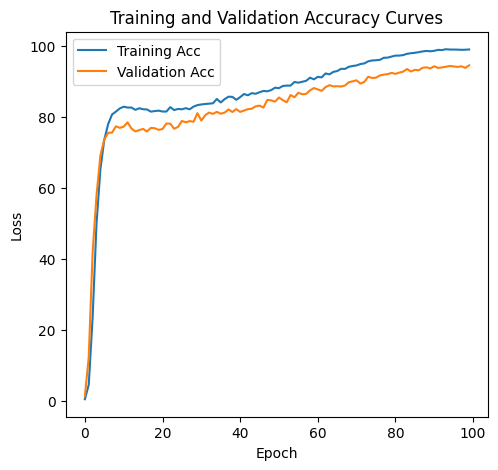

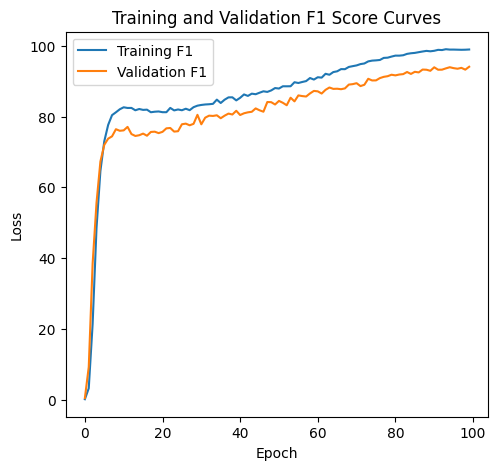

In [20]:
# 此為VGG_S
def main():
    
    seed_everything(config.seed)
    
#     dataset = HandwrittenDataset(train_data)
    dataset = HandwrittenDataset(train_data, data_transforms)

    train_ids, val_ids = split_ids(train_data.shape[0], 0.8, 0.2)
    train_dataset = torch.utils.data.Subset(dataset, train_ids)
    val_dataset = torch.utils.data.Subset(dataset, val_ids)
#     test_dataset = torch.utils.data.Subset(dataset, test_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    device = config.device
    model =  Xx_CNN_xX()
#     model =  VGG16_S()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        epochs=config.epochs, 
        steps_per_epoch=train_loader.__len__(),
        max_lr=config.lr,
    )
    
    best_val_loss = float("inf")
    history = {
        "train": {
            "loss": [],
            "acc": [],
            "f1": []
        },
        "valid": {
            "loss": [],
            "acc": [],
            "f1": [],
            "mis": []#加上misclassification rate
        },
    }
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
        valid_loss, valid_acc, valid_f1 = validation(model, val_loader, criterion, device)
        valid_mis = 100 - valid_acc
        
        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)
        history["valid"]["mis"].append(valid_mis)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid Misclassification Rate: {valid_mis:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')
    
        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint.pth")
            #儲存(object, 位址)
            
    best_ckpt = torch.load("checkpoint.pth", map_location=device)
    #load ckpt onto device
    model.load_state_dict(best_ckpt["model"])
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    
        
if __name__ == "__main__":
    main()

In [21]:
# 用Sofumax去設一個域值，機率低於域值則設為-1

In [22]:
# 讀取最佳模型
model = VGG16_S()
state_dict = torch.load("checkpoint.pth")
#讀取模型到state_dict
model.load_state_dict(state_dict["model"])
#torch.nn.Module.load_state_dict: 
#Loads a model’s parameter dictionary using a deserialized state_dict.
#用最佳模型參數

RuntimeError: Error(s) in loading state_dict for VGG16_S:
	Missing key(s) in state_dict: "features.3.weight", "features.3.bias", "features.9.weight", "features.9.bias", "features.12.weight", "features.12.bias". 
	Unexpected key(s) in state_dict: "features.2.weight", "features.2.bias", "features.2.running_mean", "features.2.running_var", "features.2.num_batches_tracked", "features.4.weight", "features.4.bias", "features.6.running_mean", "features.6.running_var", "features.6.num_batches_tracked", "features.8.weight", "features.8.bias", "features.10.weight", "features.10.bias", "features.10.running_mean", "features.10.running_var", "features.10.num_batches_tracked". 
	size mismatch for features.6.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for classifier.0.weight: copying a param with shape torch.Size([2048, 9216]) from checkpoint, the shape in current model is torch.Size([2048, 25088]).

In [ ]:
class TestDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        self.paths = np.array(df['file_path']) # 影像路徑
        
        
    def __getitem__(self, idx):
        img_name = os.path.join(config.root, self.paths[idx])
        image = Image.open(img_name)
#         transform = transforms.ToTensor()
#         image = transform(image)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image
        
    def __len__(self):
        return self.df.shape[0]


test_transforms = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.LANCZOS),  # 使用高质量插值方法
    transforms.ToTensor(),  # 将图像转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

In [ ]:
def test(model, test_loader, device, threshold=0.3):
    model.eval()
    model.to(device)
    predictions, probability = [], []
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device=device, dtype=torch.float)

            logits = model(images)
            prob = logits.softmax(dim=1)
            max_prob, preds = torch.max(prob, dim=1)
            
            # Apply threshold: if max_prob < threshold, set pred to -1
            preds[max_prob < threshold] = -1

            predictions.append(preds)
            probability.append(prob)

        # Concatenate predictions and probabilities
        predictions = torch.cat(predictions)
        probability = torch.cat(probability)
        
    return predictions, probability


In [ ]:
test_df = pd.read_csv(config.root+'/test.csv')
test_dataset = TestDataset(test_df, test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
predictions, probability = test(model, test_loader, config.device)

In [ ]:
probability = probability.cpu().numpy()
predictions = predictions.cpu().numpy()
# 組成matrix
data = np.concatenate((probability, predictions.reshape(-1, 1)), axis=1)

In [ ]:
dic = {'ID':range(0,22567),
       'Target':predictions}
dic['ID'] = ['test/{}.png'.format(i) for i in dic['ID']]
sub = pd.DataFrame(dic)
sub.to_csv('/kaggle/working/sub.csv', index = False)